# Install Dependencies

In [ ]:
!pip install pydub

In [3]:
import os
from pydub import AudioSegment, silence
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Extraction

Extract pauses from each audio file

In [19]:
base_folder = "Nemours database-20241222/SPEECH/SENT" # path to SENT file from Nemours database
min_silence_len = 250  # Minimum length of silence in milliseconds
silence_thres = 15 # Minimum threshold of silence in dBFS would be audio dBFS minus this value

In [20]:
data = []

In [22]:
for participant_folder in tqdm(os.listdir(base_folder)):
    participant_path = os.path.join(base_folder, participant_folder)

    if os.path.isdir(participant_path):
        wav_folder = os.path.join(participant_path, "WAV")

        if os.path.exists(wav_folder):
            for audio_file in os.listdir(wav_folder):
                if audio_file.endswith(".WAV"):
                    if audio_file.startswith("JP"):
                        name = "HC " + participant_folder
                    else:
                        name = participant_folder
                    audio_path = os.path.join(wav_folder, audio_file)

                    # Load the audio file, try except to avoid errors with impaired files
                    try:
                        audio = AudioSegment.from_file(audio_path)
                    except:
                        print(audio_path)

                    silence_thresh = audio.dBFS - silence_thres # Minimum threshold of silence in dFBS

                    pauses = silence.detect_silence(audio, min_silence_len=min_silence_len, silence_thresh=silence_thresh)

                    if len(pauses) > 0:

                        for start, end in pauses:
                            data.append({
                                "Participant": name,
                                "Audio File": audio_file,
                                "Pause Start (ms)": start,
                                "Pause End (ms)": end,
                                "Pause Duration (ms)": end - start
                            })

  0%|          | 0/12 [00:00<?, ?it/s]

/content/SENT/RL/WAV/JPRL39.WAV


100%|██████████| 12/12 [01:22<00:00,  6.87s/it]


In [23]:
df = pd.DataFrame(data)

In [24]:
df.head()

,Participant,Audio File,Pause Start (ms),Pause End (ms),Pause Duration (ms)
0,RL,RL30.WAV,1110,1792,682
1,RL,RL30.WAV,2214,2773,559
2,RL,RL30.WAV,3282,3907,625
3,RL,RL70.WAV,907,1639,732
4,RL,RL70.WAV,1969,2697,728


In [25]:
df.to_csv("pauses_data.csv", index=False)

# Data Aggregation

Aggregate number of pauses and their duration

By audio file

In [26]:
grouped_df = df.groupby(["Participant", "Audio File"]).agg(
    num_pauses=("Pause Duration (ms)", "count"),  # Count pauses in each file
    avg_pause_duration=("Pause Duration (ms)", "mean")  # Average pause duration in each file
).reset_index()

In [27]:
grouped_df.head()

,Participant,Audio File,num_pauses,avg_pause_duration
0,BB,BB1.WAV,1,407.0
1,BB,BB11.WAV,2,475.0
2,BB,BB12.WAV,1,292.0
3,BB,BB13.WAV,1,406.0
4,BB,BB14.WAV,1,503.0


In [28]:
grouped_df.to_csv("aggregated_file.csv")

By participant

In [29]:
aggregated_participant = grouped_df.groupby("Participant").agg(
    avg_num_pauses=("num_pauses", "mean"),  # Mean number of pauses per participant
    avg_pause_duration=("avg_pause_duration", "mean")  # Mean average duration of pauses per participant
).reset_index()

In [30]:
aggregated_participant.head()

,Participant,avg_num_pauses,avg_pause_duration
0,BB,1.757576,402.528030
1,BK,3.109589,1229.588226
2,BV,1.500000,407.204710
3,FB,1.779412,377.274510
4,HC BB,1.058824,293.000000


In [31]:
aggregated_participant.to_csv('aggregated_participant.csv')

# Data Vis

Define participants order to place patients and matched healthy controls near each other

In [32]:
custom_order = [
    "BB", "HC BB", "BK", "HC BK", "BV", "HC BV", "FB", "HC FB",
    "JF", "HC JF", "KS", "HC KS", "RK", "HC RK", "RL", "HC RL",
    "SC", "HC SC", "LL", "HC LL", "MH", "HC MH"
]

In [33]:
aggregated_participant["Group"] = aggregated_participant["Participant"].apply(lambda x: "Healthy Control" if "HC" in x else "Patient")
aggregated_participant["Participant"] = pd.Categorical(aggregated_participant["Participant"], categories=custom_order, ordered=True)
aggregated_participant = aggregated_participant.sort_values("Participant")

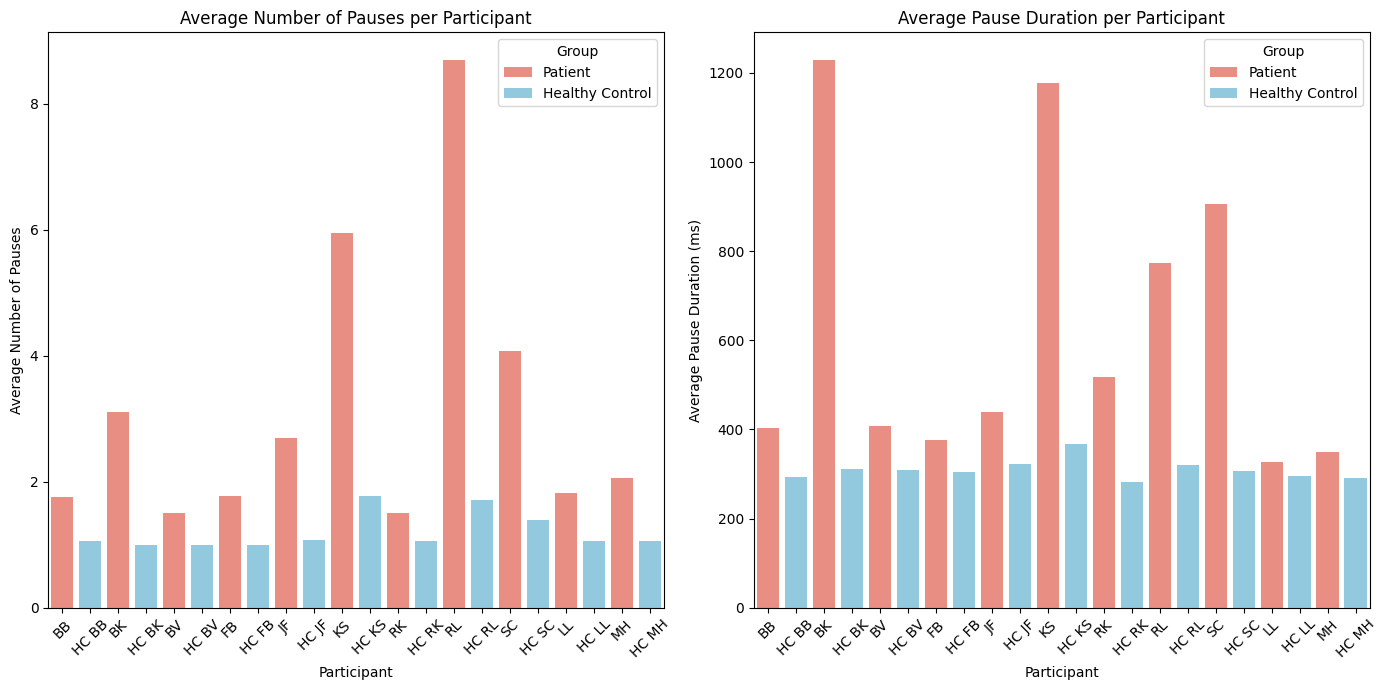

In [34]:
plt.figure(figsize=(14, 7))

palette = {"Healthy Control": "skyblue", "Patient": "salmon"}

plt.subplot(1, 2, 1)
sns.barplot(
    x='Participant', y='avg_num_pauses', data=aggregated_participant,
    hue='Group', palette=palette, dodge=False
)
plt.title('Average Number of Pauses per Participant')
plt.xticks(rotation=45)
plt.xlabel('Participant')
plt.ylabel('Average Number of Pauses')


plt.subplot(1, 2, 2)
sns.barplot(
    x='Participant', y='avg_pause_duration', data=aggregated_participant,
    hue='Group', palette=palette, dodge=False
)
plt.title('Average Pause Duration per Participant')
plt.xticks(rotation=45)
plt.xlabel('Participant')
plt.ylabel('Average Pause Duration (ms)')

plt.tight_layout()

plt.show()